# Predicting Sales Challenge

## Final project for the "How to win a data science competition" Coursera course

Dataset provided by Russian software firm, IC Company

## Description

- sales_train.csv - the training set. Daily historical data from January 2013 to October 2015.
- test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.
- items.csv - supplemental information about the items/products.
- item_categories.csv  - supplemental information about the items categories.
- shops.csv- supplemental information about the shops.

- ID - an Id that represents a (Shop, Item) tuple within the test set
- shop_id - unique identifier of a shop
- item_id - unique identifier of a product
- item_category_id - unique identifier of item category
- item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
- item_price - current price of an item
- date - date in format dd/mm/yyyy
- date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
- item_name - name of item
- shop_name - name of shop
- item_category_name - name of item category

## Looking at Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from sklearn import *

C:\Users\josh\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\josh\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
C:\Users\josh\Anaconda3\lib\site-packages\sklearn\learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


In [3]:
sales_df = pd.read_csv('sales_train.csv.gz')
items_df = pd.read_csv('items.csv')
item_cats_df = pd.read_csv('item_categories.csv')
shops_df = pd.read_csv('shops.csv')

In [4]:
sales_df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [5]:
items_df.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [6]:
item_cats_df.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [7]:
shops_df.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [8]:
# Looking at how the testing data looks like
test = pd.read_csv('test.csv.gz')
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


## Combining training data into one coherent dataset

In [9]:
items_data = pd.merge(items_df, item_cats_df, on='item_category_id')
data = pd.merge(sales_df, shops_df, on='shop_id')

In [10]:
train = pd.merge(data, items_data, on='item_id')
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name
0,02.01.2013,0,59,22154,999.0,1.0,"Ярославль ТЦ ""Альтаир""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
1,02.01.2013,0,25,22154,999.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
2,03.01.2013,0,25,22154,999.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
3,20.01.2013,0,25,22154,999.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
4,23.01.2013,0,25,22154,999.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray


In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2935849 entries, 0 to 2935848
Data columns (total 10 columns):
date                  object
date_block_num        int64
shop_id               int64
item_id               int64
item_price            float64
item_cnt_day          float64
shop_name             object
item_name             object
item_category_id      int64
item_category_name    object
dtypes: float64(2), int64(4), object(4)
memory usage: 246.4+ MB


## Drop Duplicates

In [12]:
# Drop duplcated rows, and keep only the first one
print('Before Dropping Duplicates: ', train.shape)
train.drop_duplicates(subset=['date', 'date_block_num', 'shop_id', 'item_id', 'item_cnt_day'],
                      keep='first', inplace=True)
train.reset_index(drop=True, inplace=True)
print('After Dropping Duplicates: ', train.shape)

Before Dropping Duplicates:  (2935849, 10)
After Dropping Duplicates:  (2935825, 10)


## Checking for Unreasonable Values

In [13]:
# item price
print(train.item_price.value_counts().sort_index(ascending=False))

 307980.000000       1
 59200.000000        1
 50999.000000        1
 49782.000000        1
 42990.000000        4
 42000.000000        1
 41990.000000        3
 40991.000000        1
 40900.000000        1
 37991.000000        2
 36990.000000        4
 35991.000000        1
 35990.000000        3
 35490.000000        5
 35300.000000        5
 35192.000000        1
 34990.000000       12
 34490.000000        1
 33990.000000        1
 33490.000000        8
 32997.500000        1
 32990.000000       57
 32490.000000        4
 32437.000000        1
 32382.000000        1
 32199.000000       16
 32092.000000        1
 31990.000000       19
 31699.000000        1
 31599.000000        1
                  ... 
 4.400000            1
 4.333333            1
 4.300000            1
 4.235294            1
 4.142857            1
 4.055556            1
 4.029126            1
 4.000000          105
 3.800000            2
 3.720000            6
 3.710000            3
 3.690000            2
 3.670000  

In [14]:
# Item Price with -1 and 307980 are outliers, so delete them
print('before train shape:', train.shape)
train = train[(train.item_price > 0) & (train.item_price < 300000)]
print('after train shape:', train.shape)

before train shape: (2935825, 10)
after train shape: (2935823, 10)


## EDA

#### Monthly Sales

Text(0.5,1,'Sales per month histogram')

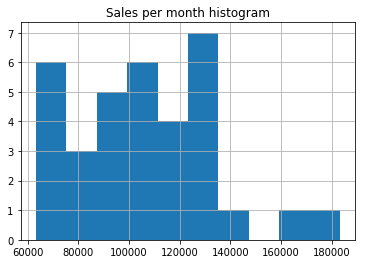

In [15]:
# Montly Sales Distribution (Target variable)
train.groupby('date_block_num').sum()['item_cnt_day'].hist()
plt.title('Sales per month histogram')

Text(0.5,1,'Sales over time')

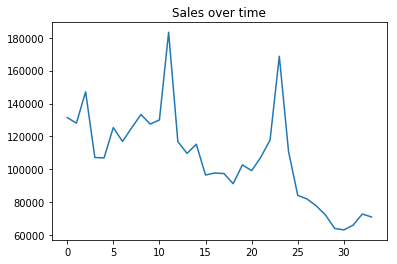

In [16]:
# Monthly Sales over Time (Target variable)
plt.plot(train.groupby('date_block_num').sum()['item_cnt_day'])
plt.title('Sales over time')

Sales peaked at the end(October-December) of each year probably due to end-of-year holiday season

#### Item Price / Shop / Item

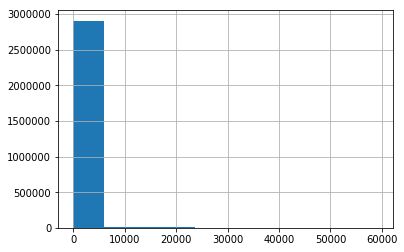

In [17]:
# item price
train.item_price.hist()

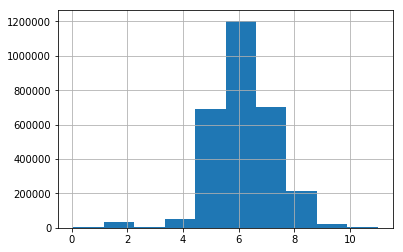

In [18]:
train.item_price.map(np.log1p).hist()

We should use log transformation for "Item Price" before we feed data to ML algorithms (Making data more like normal distribution)

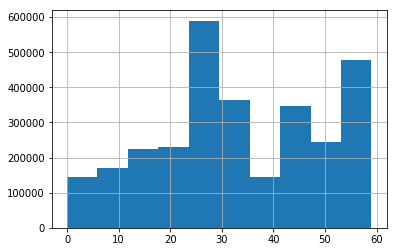

In [19]:
# shop id 
train.shop_id.hist()

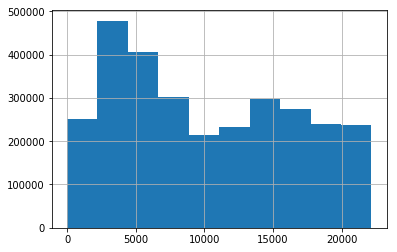

In [20]:
# item id 
train.item_id.hist()

#### Monthly Sales of different shops over time

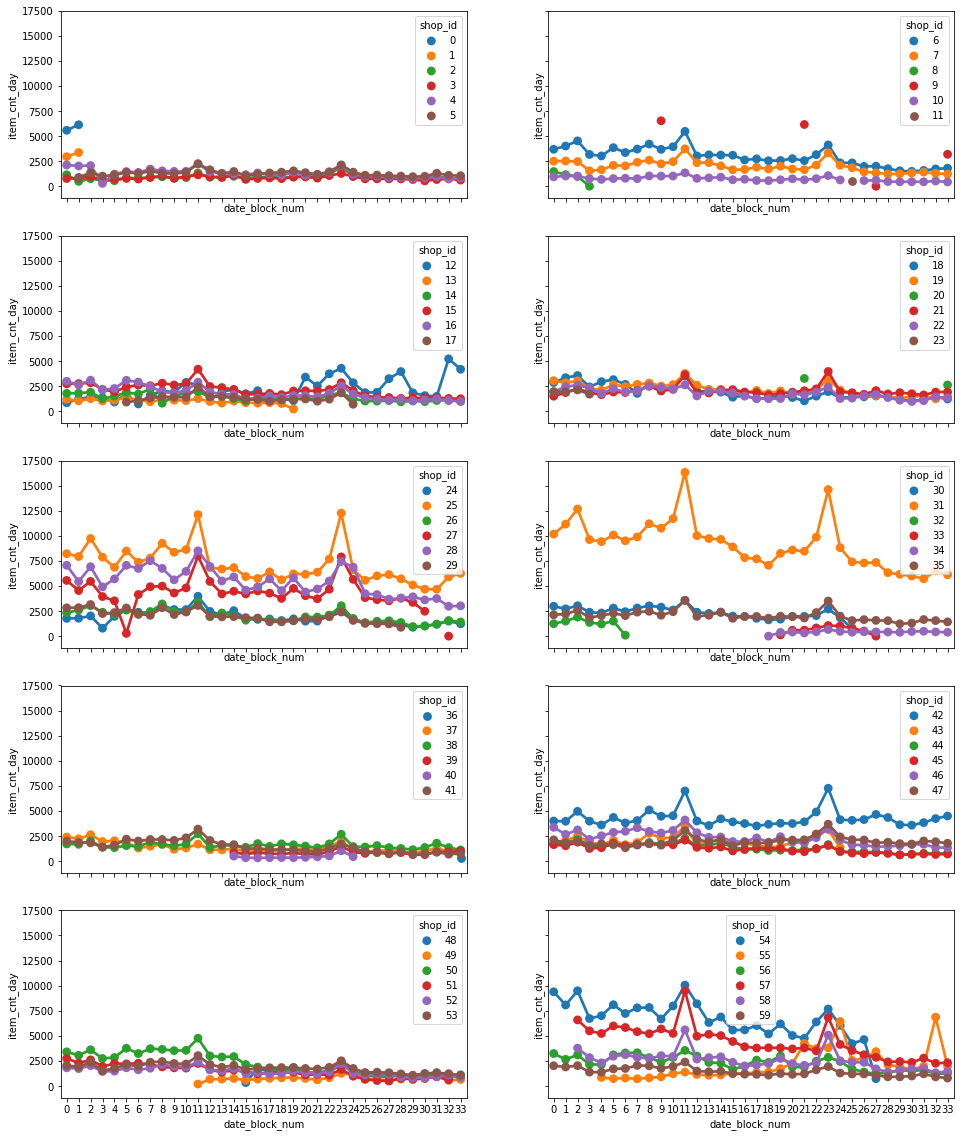

In [21]:
from math import ceil

grouped = pd.DataFrame(train.groupby(['shop_id', 'date_block_num'])['item_cnt_day'].sum().reset_index())
fig, axes = plt.subplots(nrows=5, ncols=2, sharex=True, sharey=True, figsize=(16,20))

id_per_graph = ceil(grouped.shop_id.max() / 10)
count = 0
for i in range(5):
    for j in range(2):
        sns.pointplot(x='date_block_num', y='item_cnt_day', hue='shop_id', 
                      data=grouped[np.logical_and(count*id_per_graph <= grouped['shop_id'], 
                                                  grouped['shop_id'] < (count+1)*id_per_graph)], ax=axes[i][j])
        count += 1

Even when we look at monthly sales of "each shop" (not overall) over time, we can notice peaks in sales during end of year holiday season

#### Monthly sales of different item categories over time

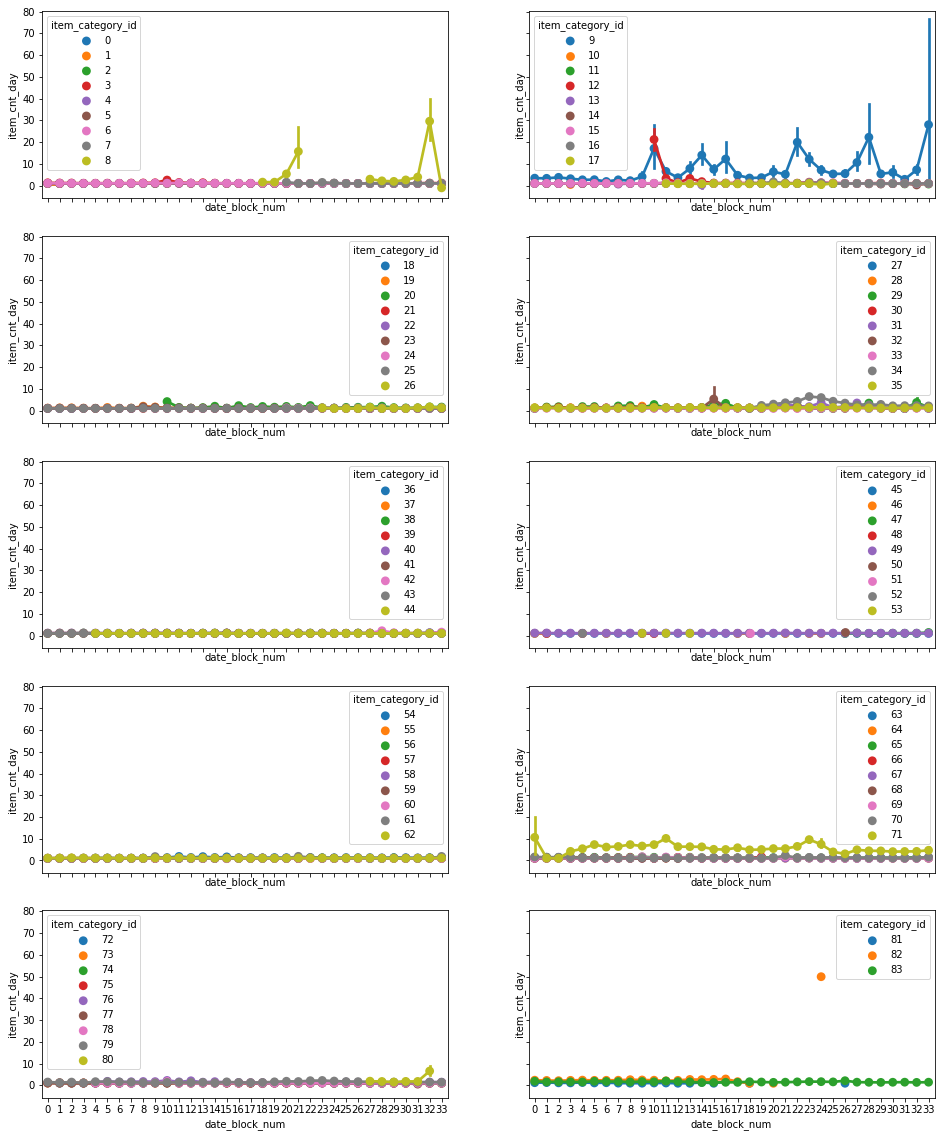

In [22]:
fig, axes = plt.subplots(nrows=5, ncols=2, sharex=True, sharey=True, figsize=(16,20))
id_per_graph = ceil(train.item_category_id.max() / 10)
count = 0
for i in range(5):
    for j in range(2):
        sns.pointplot(x='date_block_num', y='item_cnt_day', hue='item_category_id', 
                      data=train[np.logical_and(count*id_per_graph <= train['item_category_id'], 
                                                train['item_category_id'] < (count+1)*id_per_graph)], 
                      ax=axes[i][j])
        count += 1

Item Category 9 has several conspicuous peaks. There are peaks not only during end-of-year holidays but also during some Spring and Summer periods.(presumably during Spring and Summer breaks?)

## Feature Engineering

In [23]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2935823 entries, 0 to 2935824
Data columns (total 10 columns):
date                  object
date_block_num        int64
shop_id               int64
item_id               int64
item_price            float64
item_cnt_day          float64
shop_name             object
item_name             object
item_category_id      int64
item_category_name    object
dtypes: float64(2), int64(4), object(4)
memory usage: 246.4+ MB


In [24]:
# make "year","month" features
train['date'] = pd.to_datetime(train['date'], format='%d.%m.%Y')
train['month'] = train['date'].dt.month
train['year'] = train['date'].dt.year
train = train.drop(['date'], axis=1)

In [25]:
# Make Monthly Sales
train = train.groupby([c for c in train.columns if c not in ['item_cnt_day']], as_index=False)[['item_cnt_day']].sum()

In [26]:
train = train.rename(columns={'item_cnt_day':'item_cnt_month'})

# Make Monthly Mean
monthly_mean = train[['shop_id','item_id','item_cnt_month']].groupby(['shop_id','item_id'], as_index=False)[['item_cnt_month']].mean()

monthly_mean = monthly_mean.rename(columns={'item_cnt_month':'item_cnt_month_mean'})
monthly_mean.head()

,shop_id,item_id,item_cnt_month_mean
0,0,30,31.0
1,0,31,11.0
2,0,32,8.0
3,0,33,3.0
4,0,35,7.5


In [27]:
# Merge monthy mean feature 
train = pd.merge(train, monthly_mean, how='left', on=['shop_id','item_id'])

In [28]:
#Text Features using 'item name'
feature_cnt = 25
tfidf = feature_extraction.text.TfidfVectorizer(max_features=feature_cnt)
train['item_name_len'] = train['item_name'].map(len) #Lenth of Item Description
train['item_name_wc'] = train['item_name'].map(lambda x: len(str(x).split(' '))) #Item Description Word Count
txtFeatures = pd.DataFrame(tfidf.fit_transform(train['item_name']).toarray())
cols = txtFeatures.columns
for i in range(feature_cnt):
    train['item_name_tfidf_' + str(i)] = txtFeatures[cols[i]]

In [29]:
#Text Features using 'item category'
feature_cnt = 25
tfidf = feature_extraction.text.TfidfVectorizer(max_features=feature_cnt)
train['item_category_name_len'] = train['item_category_name'].map(len)  #Length of Item Category Description
train['item_category_name_wc'] = train['item_category_name'].map(lambda x: len(str(x).split(' '))) #Item Category Description Word Count
txtFeatures = pd.DataFrame(tfidf.fit_transform(train['item_category_name']).toarray())
cols = txtFeatures.columns
for i in range(feature_cnt):
    train['item_category_name_tfidf_' + str(i)] = txtFeatures[cols[i]]

In [30]:
#Text Features using 'shop name'
feature_cnt = 25
tfidf = feature_extraction.text.TfidfVectorizer(max_features=feature_cnt)
train['shop_name_len'] = train['shop_name'].map(len)  #Length of Shop Name
train['shop_name_wc'] = train['shop_name'].map(lambda x: len(str(x).split(' '))) #Shop Name Word Count
txtFeatures = pd.DataFrame(tfidf.fit_transform(train['shop_name']).toarray())
cols = txtFeatures.columns
for i in range(feature_cnt):
    train['shop_name_tfidf_' + str(i)] = txtFeatures[cols[i]]

## Preparing Test Data Set

In [31]:
test['month'] = 11
test['year'] = 2015
test['date_block_num'] = 34

In [32]:
test = pd.merge(test, pd.merge(data, items_data, on='item_id'), on=['shop_id','item_id'], how='left').fillna(0.)

In [33]:
test.drop(labels=['date','date_block_num_y'],axis=1,inplace=True)

In [34]:
# Drop duplcated rows, and keep only the first one
print('Before Dropping Duplicates: ', test.shape)
test.drop_duplicates(subset=['shop_id', 'item_id'],
                      keep='first', inplace=True)
test.reset_index(drop=True, inplace=True)
print('After Dropping Duplicates: ', test.shape)

Before Dropping Duplicates:  (1327235, 12)
After Dropping Duplicates:  (214200, 12)


In [40]:
test = test.rename(columns={'date_block_num_x':'date_block_num'})

In [41]:
test = pd.merge(test, train, on=['shop_id','item_id'], how='left').fillna(0.)

In [44]:
# Drop duplcated rows, and keep only the first one
print('Before Dropping Duplicates: ', test.shape)
test.drop_duplicates(subset=['shop_id', 'item_id'],
                      keep='first', inplace=True)
test.reset_index(drop=True, inplace=True)
print('After Dropping Duplicates: ', test.shape)

Before Dropping Duplicates:  (768966, 103)
After Dropping Duplicates:  (214200, 103)


In [50]:
test.drop(labels=['date_block_num_y',
 'item_price_y',
 'shop_name_y',
 'item_name_y',
 'item_category_id_y',
 'item_category_name_y',
 'month_y',
 'year_y',
 'item_cnt_day'],axis=1, inplace=True)

In [58]:
test = test.rename(columns={'month_x':'month','year_x':'year','date_block_num_x':'date_block_num',
                           'item_price_x':'item_price','shop_name_x':'shop_name','item_name_x':'item_name',
                           'item_category_id_x':'item_category_id','item_category_name_x':'item_category_name'})

In [61]:
test['item_cnt_month'] = 0.

In [62]:
train.shape, test.shape

((1739008, 93), (214200, 94))

In [63]:
train.to_csv('clean_train.csv', index=False)

In [64]:
test.to_csv('clean_test.csv', index=False)